## Librairies nécessaires

In [ ]:
!pip install wfdb
import wfdb
from wfdb import processing
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split

from scipy.signal import butter, filtfilt #pour filtre du bruit

from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.3/162.3 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 58.9 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


## Fonctions utiles

##### Bruits

In [ ]:
def simulation_bbgaussien(signal, snr_db):
    """
    Ajoute du bruit gaussien à un signal pour obtenir un SNR spécifié.

    signal: signal d'origine
    snr_db: niveau de SNR souhaité en décibels

    return:signal bruité
    """
    N = len(signal)
    puissance_signal = np.var(signal) #puissance du signal
    puissance_bruit = puissance_signal / (10**(snr_db / 10)) #puissance du bruit nécessaire
    bruit = np.random.normal(0, np.sqrt(puissance_bruit), N) ##génération du bruit blanc gaussien
    signal_bruite = signal + bruit #signal bruité
    return signal_bruite
#source: https://www.youtube.com/watch?v=NEnRuu0WlsU

def ajout_bruit_baseline(signal, snr_db, f=0.1, Te=1000):
    """
    Simule un bruit de baseline(respiratoire) en ajoutant une basse fréquence au signal.

    f: fréquence du bruit
    Te: T d'échantillonnage
    """
    N = len(signal)
    t = np.arange(N) / Te
    bruit = np.sin(2 * np.pi * f * t) #non-stationnaire(statistiquement)

    #ajustement du bruit en fonction du SNR
    puissance_signal = np.var(signal)
    puissance_bruit = puissance_signal / (10**(snr_db / 10))
    bruit *= np.sqrt(puissance_bruit) / np.std(bruit)

    signal_bruite = signal + bruit
    return signal_bruite
# inspiré de https://arxiv.org/html/2502.14522v1 et stackexchange


def ajout_mouvement_electrode(signal, snr_db):
    """
    Simule un mouvement des électrodes
    """
    N = len(signal)
    puissance_signal = np.var(signal)
    puissance_bruit = puissance_signal / (10**(snr_db / 10))
    bruit = np.cumsum(np.random.normal(0, np.sqrt(puissance_bruit), N))  #marche aléatoire

    #standarisation du bruit
    bruit = bruit - np.mean(bruit)
    bruit = bruit / np.std(bruit)

    #if puissance_bruit*N != np.var(bruit):
    #      print(puissance_bruit)#*(N*(N-1)/2))
    #      print(np.var(bruit))

    #puissance_bruit = np.var(bruit)
    #bruit *= np.sqrt(puissance_bruit) / np.std(bruit)
    signal_bruite = signal + bruit
    return signal_bruite

def ajout_artefacts_musculaires(signal, snr_db, Te=1000):
    """
    Simule des artefacts musculaires en ajoutant un bruit haute fréquence au signal.
    """
    N = len(signal)
    puissance_signal = np.mean(signal ** 2)
    puissance_bruit = puissance_signal / (10**(snr_db / 10))

    bruit = np.random.normal(0, np.sqrt(puissance_bruit), N) #génération du bruit gaussien
    nyquist = 0.5 * Te

    #filtrage pour garder les fréquences 0.5-70 Hz
    b, a = butter(2, [0.5 / nyquist, 70 / nyquist], btype='bandpass')
    bruit_filtre = filtfilt(b, a, bruit)

    #standarisation du bruit
    bruit_filtre = bruit_filtre - np.mean(bruit_filtre)
    bruit_filtre = bruit_filtre / np.std(bruit_filtre)

    signal_bruite = signal + bruit_filtre
    return signal_bruite

def ajout_inference_electrique(signal, snr_db, f=50, Te=1000):
    """
    Simule un bruit de baseline(respiratoire) en ajoutant une basse fréquence au signal.

    f: 50Hz(europe)
    Te: T d'échantillonnage
    """
    N = len(signal)
    t = np.arange(N) / Te
    bruit = np.sin(2 * np.pi * f * t) # non-stationnaire(statistiquement)

    #standarisation du bruit
    bruit = bruit - np.mean(bruit)
    bruit = bruit / np.std(bruit)

    #ajustement du bruit en fonction du SNR
    puissance_signal = np.var(signal)
    puissance_bruit = puissance_signal / (10**(snr_db / 10))
    bruit *= np.sqrt(puissance_bruit) / np.std(bruit)

    signal_bruite = signal + bruit
    return signal_bruite

In [ ]:
def bruitage_alea(data, fonctions_bruit, p=0.5):
    """
    Bruite aléatoirement une proportion des données avec des bruits;
      fonctions_bruit: Une liste des fonctions de bruit à utiliser,
      p: La proportion des ECG à bruiter
    """
    nb_ecg_bruiter = int(data.shape[0] * p) #part de singaux àbruiter
    idx_a_bruiter = random.sample(range(data.shape[0]), nb_ecg_bruiter)
    infos_bruit = []

    #bruiter les ECG sélectionnés
    for i in idx_a_bruiter:
        f = random.choice(fonctions_bruit) #selection aléatoire d'une  bruit
        type_bruit = fonctions_bruit.index(f)  # index du type de bruit

        #application d'UN bruit avec une SNR different par canal
        for canal in range(data.shape[2]):
            snr_db = random.uniform(6,24)
            data[i, :, canal] = f(data[i, :, canal], snr_db)
            infos_bruit.append([i, type_bruit, snr_db])
    return data, infos_bruit

#liste des fonctions de bruit
fonctions_bruit = [
    simulation_bbgaussien,
    ajout_bruit_baseline,
    ajout_mouvement_electrode,
    ajout_artefacts_musculaires,
    ajout_inference_electrique
]

##### Métrique

In [ ]:
def mse(signal_clean, signal_denoised):
    """
    Calcule l'erreur quadratique moyenne entre le signal propre et le signal débruité.
    """
    return np.mean((signal_clean - signal_denoised) ** 2)

def snr(signal_clean, signal_denoised):
    power_signal = np.var(signal_clean)#np.mean(signal_clean ** 2)
    power_noise = np.var(signal_clean - signal_denoised)#np.mean((signal_clean - signal_denoised) ** 2)
    # Pour éviter une division par zéro
    if power_noise == 0:
        return np.inf
    return 10 * np.log10(power_signal / power_noise)

def correlation(signal_clean, signal_denoised):
    """
    Calcule le coefficient de corrélation entre le signal propre et le signal débruité.
    """
    # np.corrcoef retourne une matrice 2x2, on récupère les correlations(l'élément hors diagonale)
    correlation_matrix = np.corrcoef(signal_clean, signal_denoised)
    return correlation_matrix[0, 1]

In [ ]:
def plot_and_metrics(signal, noisy_signal, denoised_signal):
    """Affiche les métriques et le graphique des signaux."""

    # Calcul des métriques
    mse_value = mse(signal, denoised_signal)
    snr_value = snr(signal, denoised_signal)
    corr_value = correlation(signal, denoised_signal)

    # Affichage des métriques
    print("MSE :", mse_value, "\n")
    print("SNR :", snr_value, "dB", "\n")
    print("Coefficient de corrélation :", corr_value)

    # Visualisation des signaux
    plt.figure(figsize=(12, 4))
    plt.plot(signal, label="Signal propre", linewidth=2)
    plt.plot(noisy_signal, label="Signal bruité", alpha=0.6)
    plt.plot(denoised_signal, label="Signal débruité", linestyle="--", linewidth=2)
    plt.xlabel("Temps (s)")
    plt.ylabel("Amplitude")
    plt.title("Comparaison des signaux")
    plt.legend()

## Bruitage des données

In [ ]:
from google.colab import drive
root = '/content/gdrive/'
drive.mount(root)

# create permanent directory in gdrive
#data_dir_path = '/MyDrive/Colab Notebooks/'
data_dir_path = '/MyDrive/' # for shared folder
os.makedirs(os.path.join(root,data_dir_path), exist_ok=True)
os.listdir(os.path.join(root,data_dir_path))

Mounted at /content/gdrive/


[]

In [ ]:
# chargement des données
chm = '/content/gdrive/MyDrive/'
#chm = '/content/gdrive/MyDrive/Colab Notebooks'
#X_100 = np.load(chm+'/ptbxl_signals_100hz.npy')
#X_500 = np.load('ptbxl_signals_500hz.npy')

#load the IDs (Y data)
#Y = np.load('/content/gdrive/MyDrive/ptbxl_ids.npy', allow_pickle=True)
X = np.load(chm+'/ptbxl_signals_100hz.npy')

In [ ]:
Y = X.copy()
X, info_br = bruitage_alea(Y, fonctions_bruit, 0.5)

**Hyperparamètres:**
* batch_size = 32
* num_epochs = 100
* lr=1e-3

In [ ]:
batch_size = 32
num_epochs = 100
lr=1e-3

# Paramètres du processus de diffusion
T = 1000  # Nombre total d'étapes de diffusion
beta_start = 1e-4
beta_end = 0.02
betas = torch.linspace(beta_start, beta_end, T).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)

In [ ]:
X_train, X_eval, y_train, y_eval = train_test_split(X, Y, test_size=0.2, random_state=42)  # 80% train
X_test, X_val, y_test, y_val = train_test_split(X_eval, y_eval, test_size=0.5, random_state=42)  # 10% val, 10% test
del X,Y,X_eval,y_eval

train_dataset = TensorDataset(torch.FloatTensor(X_train).permute(0,2,1), torch.Tensor(y_train).permute(0,2,1))
val_dataset = TensorDataset(torch.Tensor(X_val).permute(0,2,1), torch.Tensor(y_val).permute(0,2,1))
test_dataset = TensorDataset(torch.Tensor(X_test).permute(0,2,1), torch.Tensor(y_test).permute(0,2,1))
del X_train, X_val, X_test, y_train, y_val, y_test
# dimension des donnees = n, canaux, echantillon par tps


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
del train_dataset, val_dataset, test_dataset

# Diffusion débruiteure

In [ ]:
def forward_diffusion_sample(x0, t):
    """
    Ajoute du bruit à x0 pour une étape t donnée du processus de diffusion.

    x0 : signal propre (shape: [batch, channels, length])
    t  : tensor de taille [batch] contenant l'indice de l'étape de diffusion pour chaque échantillon.

    Retourne : x_t (signal bruité) et le bruit ajouté.
    """
    device = x0.device
    # Récupérer sqrt(alpha_cumprod) et sqrt(1 - alpha_cumprod) pour les indices t
    sqrt_alpha_cumprod = torch.sqrt(alphas_cumprod[t]).view(-1, 1, 1).to(device) # Reshape to match data dimensions
    sqrt_one_minus_alpha_cumprod = torch.sqrt(1 - alphas_cumprod[t]).view(-1, 1, 1).to(device) # Reshape to match data dimensions

    noise = torch.randn_like(x0)  # Generate noise with the same shape as x0
    x_t = sqrt_alpha_cumprod * x0 + sqrt_one_minus_alpha_cumprod * noise
    return x_t, noise

class DDPM(nn.Module):
    def __init__(self, input_channels=12, hidden_dim=64):
        super(DDPM, self).__init__()
        self.net = nn.Sequential(
            nn.Conv1d(input_channels, hidden_dim, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(hidden_dim, hidden_dim, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(hidden_dim, input_channels, kernel_size=3, padding=1)
        )

    def forward(self, x, t):
        # version simplifiée, nous ignorons t dans le forward(phase bruitage).
        return self.net(x)

def train_diffusion(model, train_loader, val_loader, num_epochs=100, lr=1e-3):
    """
    Boucle d'entraînement du modèle de diffusion.
    Le modèle apprend à prédire le bruit ajouté au signal.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    #for epoch in tqdm(enumerate(range(num_epochs))):
    for epoch_idx, epoch in enumerate(tqdm(range(num_epochs), desc="entrainement en cours...", leave=False)): # unpack the tuple from enumerate to epoch_idx and epoch
        model.train()
        train_loss = 0.0
        for batch in train_loader:
            x0 = batch[0]
            x0 = x0.to(device)  # x0: signal propre, shape [batch, channels, length]
            batch_size = x0.shape[0]
            # Tirer aléatoirement une étape t pour chaque échantillon
            t = torch.randint(0, T, (batch_size,), device=device)
            # Générer un signal bruité et récupérer le bruit ajouté
            x_t, noise = forward_diffusion_sample(x0, t)
            # Le modèle doit prédire le bruit ajouté
            noise_pred = model(x_t, t)
            loss = criterion(noise_pred, noise)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * batch_size

        train_loss /= len(train_loader.dataset)


        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                x0 = batch[0]
                x0 = x0[0].to(device)
                batch_size = x0.shape[0]
                t = torch.randint(0, T, (batch_size,), device=device)
                x_t, noise = forward_diffusion_sample(x0, t)
                noise_pred = model(x_t, t)
                loss = criterion(noise_pred, noise)
                val_loss += loss.item() * batch_size
        val_loss /= len(val_loader.dataset)

        if epoch_idx % 10 == 0:
            print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.6f} - Val Loss: {val_loss:.6f}")

### Entrainement+Test sur données "jouet"

In [ ]:
# Exemple d'utilisation :

# Simulation de 100 signaux ECG de 1 canal, 1000 points chacun
X = torch.sin(torch.linspace(0, 2 * np.pi, 1000)).unsqueeze(0).repeat(100, 1)  # Shape [100, 1000]
X = X.unsqueeze(1)  # Shape [100, 1, 1000] (1 canal)
X_val = torch.sin(torch.linspace(0, 2 * np.pi, 1000)).unsqueeze(0).repeat(20, 1)
X_val = X_val.unsqueeze(1)

train = TensorDataset(X)
train_loader = DataLoader(train, batch_size, shuffle=True)
val = TensorDataset(X_val)
val_loader = DataLoader(val, batch_size, shuffle=True)

#initialisation le modèle de diffusion
model = DiffusionModel(input_channels=1, hidden_dim=64)
train_diffusion(model, train_loader, val_loader, num_epochs, lr)
torch.save(model.state_dict(), f"diffusion_model_epoch_{num_epochs}.pth")

3it [00:00, 22.88it/s]

Epoch 1/100 - Train Loss: 0.482629 - Val Loss: 0.074712


15it [00:00, 23.06it/s]

Epoch 11/100 - Train Loss: 0.118188 - Val Loss: 0.015838


24it [00:01, 22.97it/s]

Epoch 21/100 - Train Loss: 0.122031 - Val Loss: 0.044535


33it [00:01, 20.70it/s]

Epoch 31/100 - Train Loss: 0.119618 - Val Loss: 0.035949


44it [00:02, 19.08it/s]

Epoch 41/100 - Train Loss: 0.122059 - Val Loss: 0.027169


53it [00:02, 18.90it/s]

Epoch 51/100 - Train Loss: 0.106208 - Val Loss: 0.018908


65it [00:03, 20.31it/s]

Epoch 61/100 - Train Loss: 0.119004 - Val Loss: 0.038732


74it [00:03, 18.65it/s]

Epoch 71/100 - Train Loss: 0.101977 - Val Loss: 0.026404


84it [00:04, 21.09it/s]

Epoch 81/100 - Train Loss: 0.105440 - Val Loss: 0.028113


93it [00:04, 23.22it/s]

Epoch 91/100 - Train Loss: 0.109642 - Val Loss: 0.010108


100it [00:04, 20.80it/s]


SNR initial 14.924598865355978 dB 

MSE : 0.26596305 

SNR : 2.8100228 dB 

Coefficient de corrélation : 0.7970896461461743


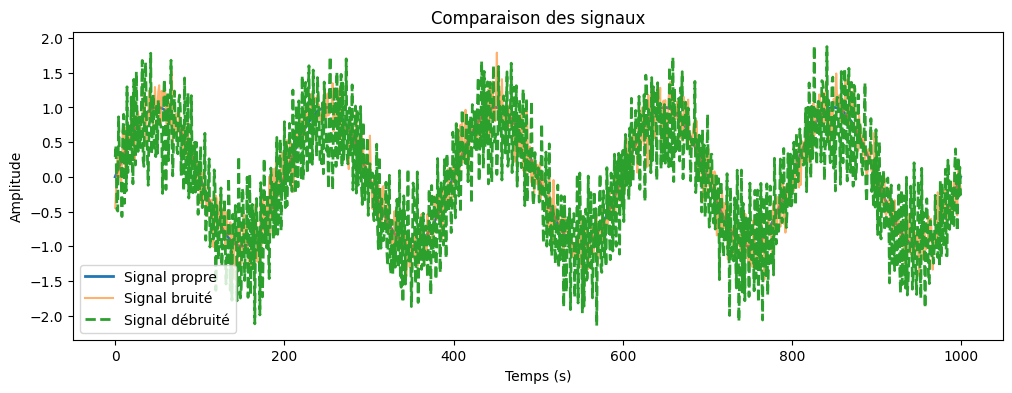

In [ ]:
N = 20  # nombre d'échantillons de test
channels = 12
length = 1000
t = torch.linspace(0, 1, length)
X_test = torch.sin(2 * np.pi * 5 * t).unsqueeze(0).repeat(N, 1).unsqueeze(1)  # signaux propres simulés


X_test_np = X_test.numpy().squeeze()  # conversion en numpy pour le bruitage
snr_np = [np.random.uniform(6, 24) for _ in range(N)]
X_test_bruite_np = np.array([simulation_bbgaussien(X_test_np[i], snr_np[i]) for i in range(N)])
X_test_bruite = torch.tensor(X_test_bruite_np).unsqueeze(1).float()

# Créez un DataLoader pour l'ensemble de test
test_dataset = TensorDataset(X_test, X_test_bruite)
test_loader = DataLoader(test_dataset, batch_size=5, shuffle=False)

# Charger le modèle (en supposant qu'il est entraîné)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()  # mode évaluation

with torch.no_grad():
    for clean, noisy in test_loader:
        clean = clean.to(device)   # signal propre
        noisy = noisy.to(device)   # signal bruité

        # Pour simplifier, on simule un processus inverse simple :
        # ici, le modèle prédit le bruit et on soustrait ce bruit au signal bruité.
        # Vous pourrez remplacer cette étape par un processus inverse complet si vous l'avez implémenté.
        # Choisir un t arbitraire (par exemple t = T-1 pour une étape finale)
        batch_size = noisy.shape[0]
        t_batch = torch.full((batch_size,), T-1, dtype=torch.long, device=device)

        noise_pred = model(noisy, t_batch)  # prédiction du bruit
        denoised = noisy - noise_pred     # estimation du signal propre

        # Conversion en numpy pour calcul des métriques
        clean_np = clean.cpu().numpy().squeeze()
        denoised_np = denoised.cpu().numpy().squeeze()
        noisy = noisy.cpu().numpy().squeeze()



# Visualisation d'un exemple
example_idx = 2
print("SNR initial", np.mean(snr_np), 'dB \n')
plot_and_metrics(clean_np[example_idx], X_test_bruite_np[example_idx], denoised_np[example_idx])

## Entrainement du modèle sur les données réelles d'apprentissage

In [ ]:
model = DDPM(input_channels=12, hidden_dim=64)

In [ ]:
train_diffusion(model, train_loader, val_loader, num_epochs, lr)

entrainement en cours...:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([12, 1000])) that is different to the input size (torch.Size([12, 12, 1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
entrainement en cours...:   1%|          | 1/100 [00:02<04:24,  2.68s/it]

Epoch 1/100 - Train Loss: 0.210601 - Val Loss: 0.060093


entrainement en cours...:  11%|█         | 11/100 [00:29<03:59,  2.69s/it]

Epoch 11/100 - Train Loss: 0.076652 - Val Loss: 0.026551


entrainement en cours...:  21%|██        | 21/100 [00:55<03:26,  2.62s/it]

Epoch 21/100 - Train Loss: 0.071817 - Val Loss: 0.025235


entrainement en cours...:  31%|███       | 31/100 [01:21<03:01,  2.63s/it]

Epoch 31/100 - Train Loss: 0.069696 - Val Loss: 0.025714


entrainement en cours...:  41%|████      | 41/100 [01:47<02:34,  2.62s/it]

Epoch 41/100 - Train Loss: 0.069385 - Val Loss: 0.023292


entrainement en cours...:  51%|█████     | 51/100 [02:13<02:07,  2.61s/it]

Epoch 51/100 - Train Loss: 0.070083 - Val Loss: 0.027958


entrainement en cours...:  61%|██████    | 61/100 [02:40<01:42,  2.62s/it]

Epoch 61/100 - Train Loss: 0.068069 - Val Loss: 0.025741


entrainement en cours...:  71%|███████   | 71/100 [03:06<01:15,  2.61s/it]

Epoch 71/100 - Train Loss: 0.070299 - Val Loss: 0.025832


entrainement en cours...:  81%|████████  | 81/100 [03:32<00:49,  2.62s/it]

Epoch 81/100 - Train Loss: 0.067036 - Val Loss: 0.028494


entrainement en cours...:  91%|█████████ | 91/100 [03:58<00:23,  2.61s/it]

Epoch 91/100 - Train Loss: 0.067645 - Val Loss: 0.029009


## Evaluation du modèle sur les données test réelles

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()  # mode évaluation

with torch.no_grad():
    for clean, noised in test_loader:
        clean = clean.to(device)   # signal propre
        noised = noised.to(device)   # signal bruité

        # Pour simplifier, on simule un processus inverse simple :
        # ici, le modèle prédit le bruit et on soustrait ce bruit au signal bruité.
        # Vous pourrez remplacer cette étape par un processus inverse complet si vous l'avez implémenté.
        # Choisir un t arbitraire (par exemple t = T-1 pour une étape finale)
        batch_size = noised.shape[0]
        t_batch = torch.full((batch_size,), T-1, dtype=torch.long, device=device)

        noise_pred = model(noised, t_batch)  # prédiction du bruit
        denoised = noised - noise_pred     # estimation du signal propre

        # Conversion en numpy pour calcul des métriques
        clean_np = clean.cpu().numpy().squeeze()
        denoised_np = denoised.cpu().numpy().squeeze()
        noised = noised.cpu().numpy().squeeze()



# Visualisation d'un exemple
example_idx = random.randint(0, len(clean_np)-1)
plot_and_metrics(clean_np[example_idx], noised[example_idx], denoised_np[example_idx])

MSE : 0.03613356

SNR : -0.023371277 dB

Coefficient de corrélation : 0.9361975995064857

In [ ]:
torch.save(model.state_dict(), f"diffusion_model_epoch_{num_epochs}.pth")
!cp diffusion_model_epoch_100.pth /content/gdrive/MyDrive/

## Breve descriptive du diffusion

* Processus de diffusion

  On définit une séquence de T étapes où le bruit est ajouté progressivement.

  La fonction forward_diffusion_sample calcule :

  $$x_t = \sqrt{\bar{α}_t}x_0 + \sqrt{1 - \bar{α}_t}ϵ$$

  où $\bar{α}_t$​ est le produit cumulatif des $α$ jusqu'à l'étape t.

* Modèle de diffusion

  Le modèle est entraîné pour prédire le bruit ϵϵ ajouté. L'objectif est de minimiser la différence entre le bruit prédit et le bruit réel (MSE).

* Boucle d'entraînement

  À chaque itération, pour chaque échantillon, on sélectionne aléatoirement un temps tt, on ajoute du bruit, puis on calcule la perte en comparant le bruit prédit par le modèle à celui qui a été effectivement ajouté.

Sources:
* Diffusion Models Beat GANs on Image Synthesis
Nichol, A. & Dhariwal, P. (2021). https://arxiv.org/abs/2105.05233

* Modèle de diffusion génération, Mémoire M2 Data Science à l'UA, mars 2025 [Rapport](https://github.com/mahamat9/diffusion_model_M2DSUA/blob/main/rapport/TER_Diffusion_Model.pdf) [Implémentation DDPM sur MNIST](https://github.com/mahamat9/diffusion_model_M2DSUA/tree/main/tibo%20-%20Mod%C3%A8les%20%C3%A0%20Difusion)